In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from glob import glob

In [3]:
import cv2

In [4]:
from skimage import io

In [5]:
from skimage.io import imread

In [6]:
import random

In [7]:
from PIL import Image, ImageOps

In [8]:
import matplotlib as mplot

In [9]:
import matplotlib.pyplot as plt

In [10]:
%matplotlib inline

In [11]:
import matplotlib.image as mpimg

In [12]:
from os.path import join

In [13]:
import numpy as np

In [14]:
import seaborn as sns
plt.style.use('fivethirtyeight')

In [15]:
import tensorflow as tf

In [16]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [17]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [18]:
from tensorflow import convert_to_tensor as ctt, clip_by_value as cbv

In [19]:
from tensorflow import random_normal as random_normal_distribution

In [20]:
from tensorflow import placeholder as ph, Variable

In [21]:
from tensorflow import variable_scope as vs, InteractiveSession, global_variables_initializer

In [22]:
from tensorflow.layers import conv2d

In [23]:
from tensorflow.nn import relu

In [24]:
from tensorflow.train import AdamOptimizer, Saver

In [25]:
from tensorflow.summary import scalar, image, merge_all, FileWriter

In [26]:
from tensorflow.losses import mean_squared_error as mse

In [27]:
cover_images_ds_path = "./CIFAR100/TRAIN/"

In [28]:
cover_images_list = glob(cover_images_ds_path+"be*/*.png")

In [29]:
files_list = cover_images_list

In [30]:
trainable=False

In [31]:
epoach_count = 100

In [32]:
logs_file_path = "./my_logs/"
endpoints_path = './my_endpoints/'

In [33]:
my_process = InteractiveSession(graph=tf.Graph())

In [34]:
result_value=0.8

In [35]:
result_format = f"result_{result_value}"

In [36]:
writer = FileWriter(join(logs_file_path,result_format),my_process.graph)

In [37]:
def display_images(images_list, title):
    display_idx=0
    fig, ax = plt.subplots(2, 5, figsize=(30, 15), tight_layout=True,  sharex=True, sharey=True)
    for i, row in enumerate(ax):
        for j, image_col in enumerate(row):
            dpi = mplot.rcParams['figure.dpi']
            img = imread(images_list[display_idx])
            height, width, depth = img.shape
            figsize = width / float(dpi), height / float(dpi)
            fig.tight_layout()
            plt.figure(figsize=figsize )
            plt.subplots_adjust(hspace=0.6)
            image_col.imshow(img)
            img_path_part_list = images_list[display_idx].split("\\")
            img_file_name = img_path_part_list[len(img_path_part_list) -1]
            image_col.set_title(img_file_name, fontsize=18)
            display_idx=display_idx+1
    plt.suptitle(title, fontsize=12)
    plt.show()

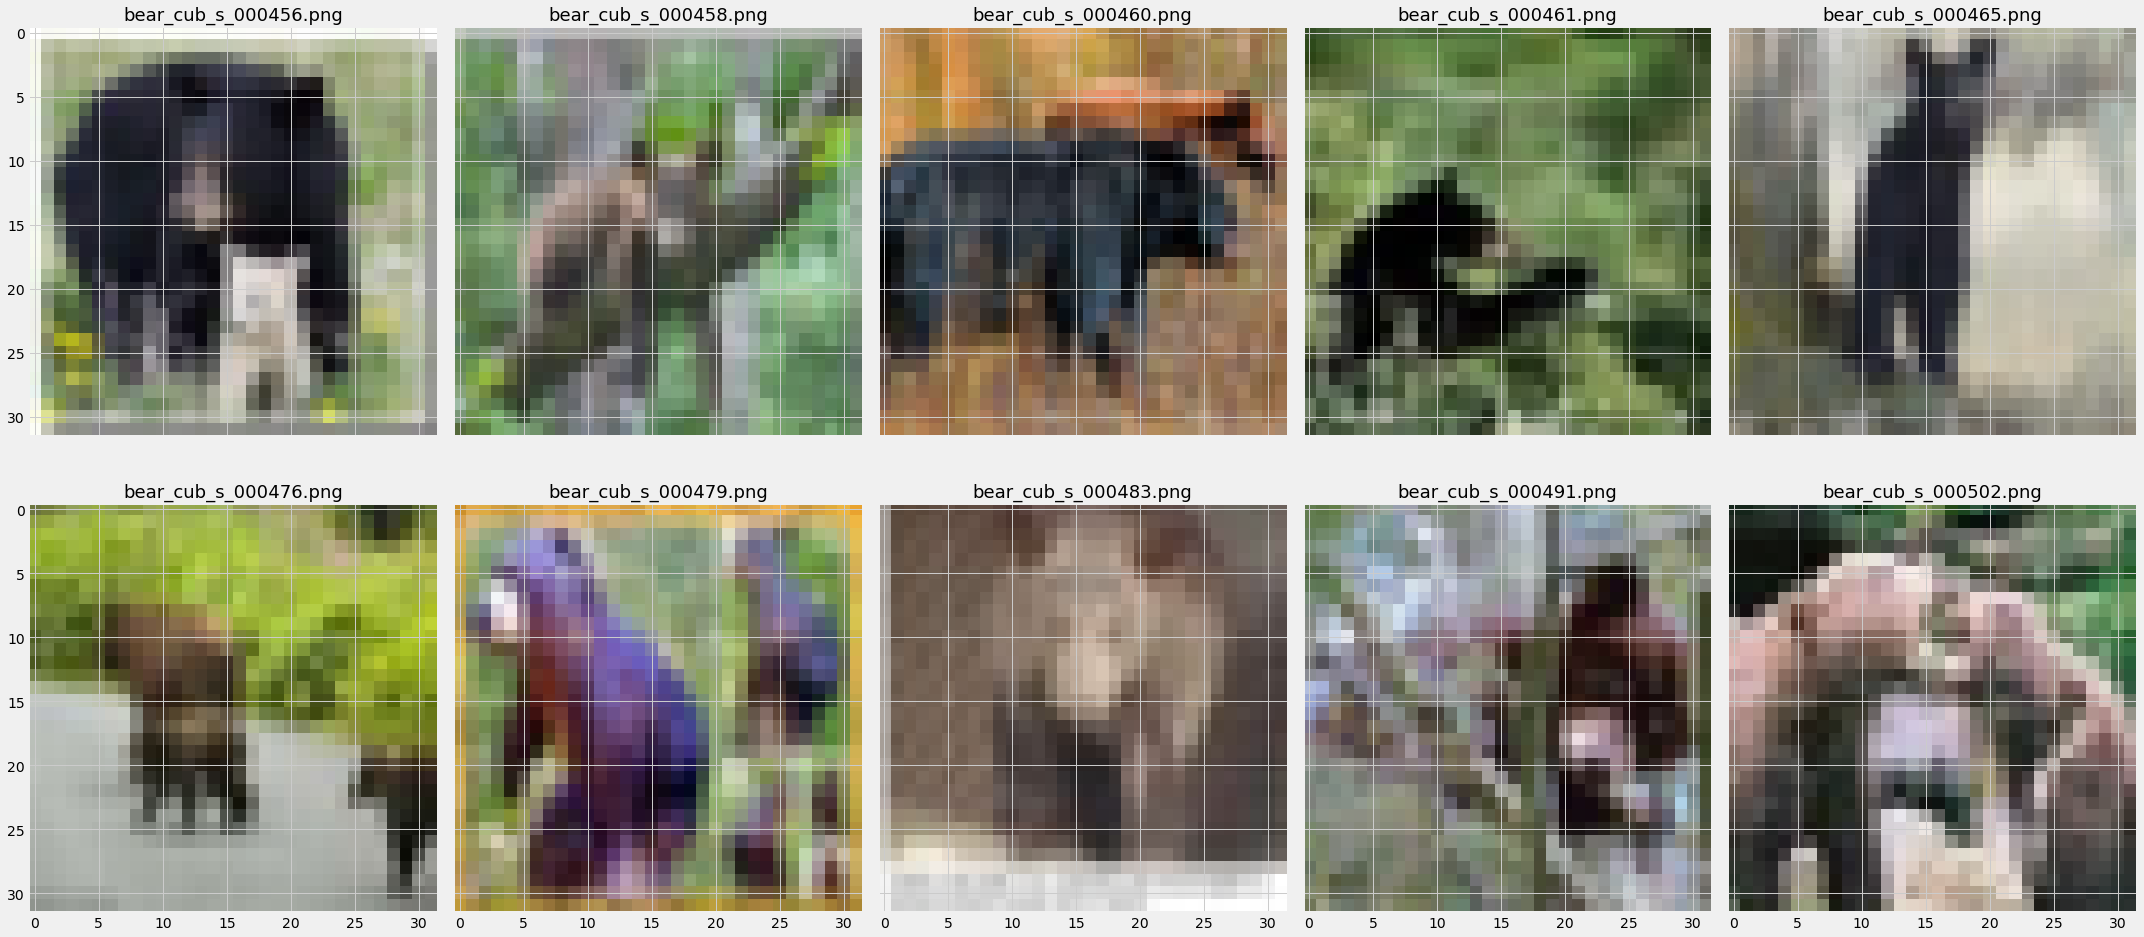

<Figure size 32x32 with 0 Axes>

<Figure size 32x32 with 0 Axes>

<Figure size 32x32 with 0 Axes>

<Figure size 32x32 with 0 Axes>

<Figure size 32x32 with 0 Axes>

<Figure size 32x32 with 0 Axes>

<Figure size 32x32 with 0 Axes>

<Figure size 32x32 with 0 Axes>

<Figure size 32x32 with 0 Axes>

<Figure size 32x32 with 0 Axes>

In [38]:
display_images(cover_images_list, 'Cover Images Observations')

In [39]:
secret_images_ds_path = "./CIFAR100/TEST/"

In [40]:
secret_images_list = glob(secret_images_ds_path+"w*/*.png")

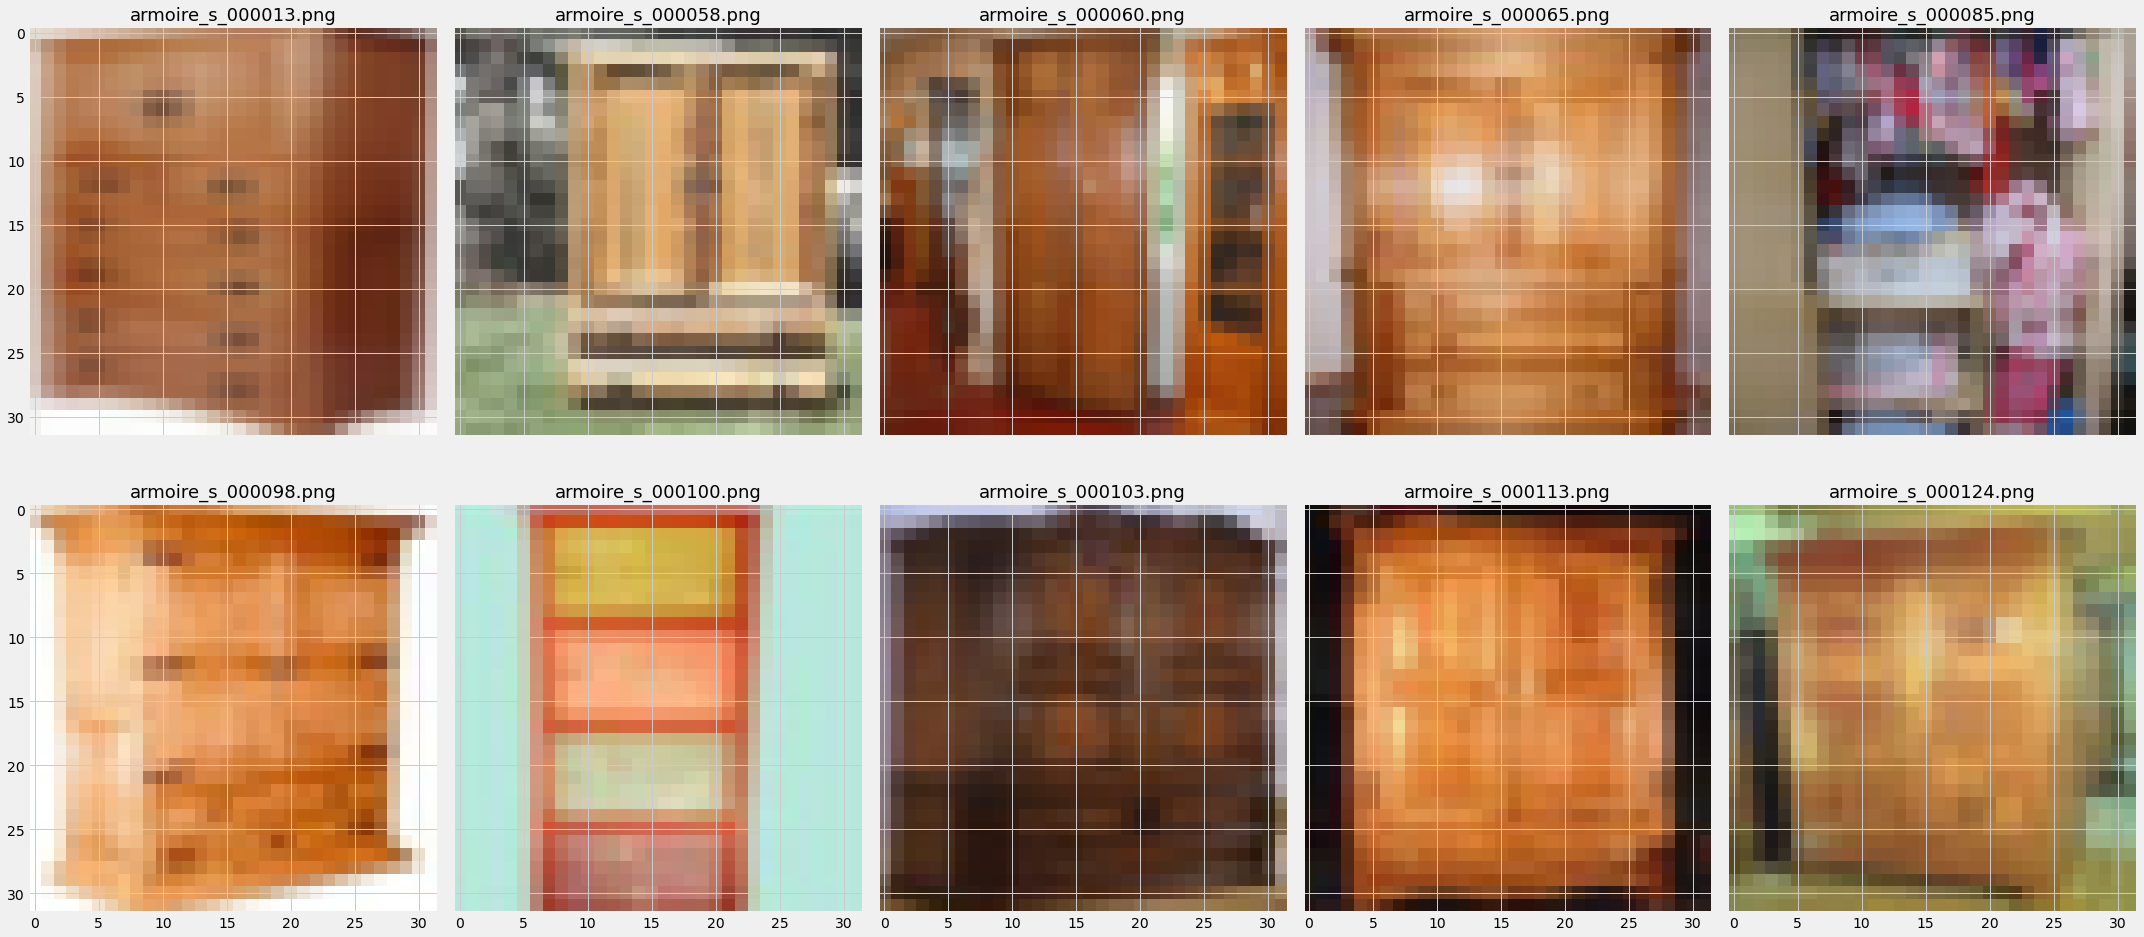

<Figure size 32x32 with 0 Axes>

<Figure size 32x32 with 0 Axes>

<Figure size 32x32 with 0 Axes>

<Figure size 32x32 with 0 Axes>

<Figure size 32x32 with 0 Axes>

<Figure size 32x32 with 0 Axes>

<Figure size 32x32 with 0 Axes>

<Figure size 32x32 with 0 Axes>

<Figure size 32x32 with 0 Axes>

<Figure size 32x32 with 0 Axes>

In [41]:
display_images(secret_images_list, 'Secret Images Observations')

In [42]:
cifar_image_size = (32,32)

In [43]:
learning_rate = .0001

In [44]:
mean_list = [0.485, 0.456, 0.406]

In [45]:
mean = np.array(mean_list)

In [46]:
variance_list = [0.229, 0.224, 0.225]

In [47]:
variance = np.array(variance_list)

In [48]:
def change_min_max(tensor):
    t = tensor * ctt(variance_list) + ctt(mean_list)
    return cbv(t,0,1)

In [49]:
def get_random_data_from_normal_distribution(data):
    return data + random_normal_distribution(shape=tf.shape(data), mean=0.0, stddev=0.1, dtype=tf.float32) 

In [50]:
def get_final_secret_cover_losses(secret_image_actual_data,secret_image_predicted_data,cover_image_actual_data,cover_image_predicted_data):
    with vs("mse"):
        secret_mse_loss = mse(secret_image_actual_data,secret_image_predicted_data)
        cover_mse_loss = mse(cover_image_actual_data,cover_image_predicted_data)
        return secret_mse_loss , cover_mse_loss 

In [51]:
def mse_losses(secret_image_data,cover_image_data,overall_data_step):
    preparation_architecture_output = define_preparation_architecture(secret_image_data)
    hiding_architecture_output = define_hiding_architecture(cover_image_data,preparation_architecture_output)
    random_normal_distribution_output = get_random_data_from_normal_distribution(hiding_architecture_output)
    reveal_architecture_output = define_reveal_architecture(random_normal_distribution_output)
    
    secret_mse_loss, cover_mse_loss = get_final_secret_cover_losses(secret_image_data,reveal_architecture_output,cover_image_data,hiding_architecture_output)
    b_value = tf.constant(0.5,name="b_value")
    total_mse_loss = cover_mse_loss + b_value * secret_mse_loss
    return preparation_architecture_output, hiding_architecture_output, random_normal_distribution_output, reveal_architecture_output, secret_mse_loss, cover_mse_loss, total_mse_loss

In [52]:
def test_mse_losses(secret_image_data,cover_image_data,overall_data_step, operation_type=""):
    preparation_architecture_output = define_preparation_architecture(secret_image_data, "test_")
    hiding_architecture_output = define_hiding_architecture(cover_image_data,preparation_architecture_output, "test_")
    random_normal_distribution_output = get_random_data_from_normal_distribution(hiding_architecture_output)
    reveal_architecture_output = define_reveal_architecture(random_normal_distribution_output, "test_")
    
    secret_mse_loss, cover_mse_loss = get_final_secret_cover_losses(secret_image_data,reveal_architecture_output,cover_image_data,hiding_architecture_output)
    b_value = tf.constant(0.5,name="b_value")
    total_mse_loss = cover_mse_loss + b_value * secret_mse_loss
    return preparation_architecture_output, hiding_architecture_output, random_normal_distribution_output, reveal_architecture_output, secret_mse_loss, cover_mse_loss, total_mse_loss

In [53]:
def images_normalization(imgs):
    print(type(imgs))
    return (imgs -  mean) / variance

In [80]:
def images_denormalization(imgages_list,can_limit=True):
    imgages_list= (imgages_list * variance) + mean
    
    if can_limit:
        imgages_list= np.clip(imgages_list,0,1)
    return imgages_list

In [55]:
def get_cover_secret_images_list(images_file_list,batch_size=32):
   
    cover_list = []
    secret_list = []

    for i in range(batch_size):
        img_secret_path = random.choice(images_file_list)
        img_secret = Image.open(img_secret_path).convert("RGB")
        img_secret = np.array(ImageOps.fit(img_secret,cifar_image_size),dtype=np.float32)
        img_secret /= 255.
        secret_list.append(img_secret)
        
        img_cover_path = random.choice(images_file_list)
        img_cover = Image.open(img_cover_path).convert("RGB")   
        img_cover = np.array(ImageOps.fit(img_cover,cifar_image_size),dtype=np.float32)
        img_cover /= 255.
        cover_list.append(img_cover)
        
    cover_list,secret_list = images_normalization(np.array(cover_list)) , images_normalization(np.array(secret_list))

    return cover_list,secret_list

In [56]:
size_of_the_batch = 8

In [57]:
steps_count = len(cover_images_list)//size_of_the_batch + 1

In [58]:
activation_function = relu

In [59]:
def create_convolution_layer(input_tensor, filters, kernel_size, layer_name):
    layer_1 = conv2d(inputs=input_tensor,filters=filters,kernel_size=kernel_size,padding='same',name=layer_name+"-01",activation=activation_function)
    layer_1 = conv2d(inputs=layer_1,filters=filters,kernel_size=kernel_size,padding='same',name=layer_name+"02",activation=activation_function)
    layer_1 = conv2d(inputs=layer_1,filters=filters,kernel_size=kernel_size,padding='same',name=layer_name+"03",activation=activation_function)
    layer_1 = conv2d(inputs=layer_1,filters=filters,kernel_size=kernel_size,padding='same',name=layer_name+"04",activation=activation_function)
    return layer_1

In [60]:
def create_final_layer(input_tensor, filters, kernel_size, layer_name):
    intermeidate_layer_5 = tf.layers.conv2d(inputs=input_tensor,filters=50,kernel_size=kernel_size,padding='same',name=layer_name+"-05",activation=activation_function)
    intermeidate_layer_4 = tf.layers.conv2d(inputs=input_tensor,filters=50,kernel_size=kernel_size - 1,padding='same',name=layer_name+"-04",activation=activation_function)
    intermeidate_layer_3 = tf.layers.conv2d(inputs=input_tensor,filters=50,kernel_size=kernel_size - 2,padding='same',name=layer_name+"-03",activation=activation_function)
        
    final_layer = tf.concat([intermeidate_layer_5,intermeidate_layer_4,intermeidate_layer_3],axis=3,name=layer_name+'_final_layer')
    return final_layer

In [61]:
def define_preparation_architecture(secret_image_data, operation_type="train_"):
    
    with vs('preparation_arch_scope', reuse=tf.AUTO_REUSE):
        
        first_conv2d_layer = create_convolution_layer(secret_image_data, 50, 3, operation_type+"prep_conv2d_3")
        second_conv2d_layer = create_convolution_layer(secret_image_data, 50, 4, operation_type+"prep_conv2d_4")
        third_conv2d_layer = create_convolution_layer(secret_image_data, 50, 5, operation_type+"prep_conv2d_5")
            
        intermediate_layer = tf.concat([first_conv2d_layer,second_conv2d_layer,third_conv2d_layer],axis=3,name=operation_type+'preparation_layer_1')
        
        preparation_network_final_layer = create_final_layer(intermediate_layer, 50, 5, operation_type+"intermediate_layer")
        
        return preparation_network_final_layer

In [62]:
def define_hiding_architecture(cover_image_data,preparation_network_op_data, operation_type="train_"):
    
    with vs('hiding_arch_scope'):
        cover_plus_prep_output_data = tf.concat([cover_image_data,preparation_network_op_data],axis=3,name=operation_type+'features_addition')
        
        first_conv2d_layer = create_convolution_layer(cover_plus_prep_output_data, 50, 3, operation_type+"hiding_conv2d_3")
        second_conv2d_layer = create_convolution_layer(cover_plus_prep_output_data, 50, 4, operation_type+"hiding_conv2d_4")
        third_conv2d_layer = create_convolution_layer(cover_plus_prep_output_data, 50, 5, operation_type+"hiding_conv2d_5")
        
        intermediate_layer = tf.concat([first_conv2d_layer,second_conv2d_layer,third_conv2d_layer],axis=3,name=operation_type+'hiding_layer_1')
        hiding_network_final_layer = create_final_layer(intermediate_layer, 50, 5, operation_type+"hiding_intermediate_layer")
        hiding_network_output_layer = conv2d(inputs=hiding_network_final_layer,filters=3,kernel_size=1,padding='same',name=operation_type+'hiding_output')
        
        return hiding_network_output_layer

In [63]:
def define_reveal_architecture(reveal_input_data, operation_type="train_"):
    
    with vs('reveal_arch_scope'):
        
        first_conv2d_layer = create_convolution_layer(reveal_input_data, 50, 3, operation_type+"reveal_conv2d_3")
        second_conv2d_layer = create_convolution_layer(reveal_input_data, 50, 4, operation_type+"reveal_conv2d_4")
        third_conv2d_layer = create_convolution_layer(reveal_input_data, 50, 5, operation_type+"reveal_conv2d_5")
        
        intermediate_layer = tf.concat([first_conv2d_layer,second_conv2d_layer,third_conv2d_layer],axis=3,name=operation_type+'reveal_layer_1')
        
        reveal_network_final_layer = create_final_layer(intermediate_layer, 50, 5, operation_type+"reveal_intermediate_layer")
        
        output = conv2d(inputs=reveal_network_final_layer,filters=3,kernel_size=1,padding='same',name=operation_type+'reveal_output')

        return output

In [64]:
def network_training_process(secret_image_data,cover_image_data,overall_data_step):
    
    preparation_architecture_output, hiding_architecture_output, random_normal_distribution_output, reveal_architecture_output, secret_mse_loss, cover_mse_loss, total_mse_loss = mse_losses(secret_image_data,cover_image_data,overall_data_step)
    
    train_adam_output = AdamOptimizer(learning_rate).minimize(total_mse_loss,global_step=overall_data_step)
    
    scalar('loss', total_mse_loss,family='train')
    scalar('reveal_net_loss', secret_mse_loss,family='train')
    scalar('cover_net_loss', cover_mse_loss,family='train')

    image('secret',change_min_max(secret_image_data),max_outputs=1,family='train')
    image('cover',change_min_max(cover_image_data),max_outputs=1,family='train')
    image('hidden',change_min_max(hiding_architecture_output),max_outputs=1,family='train')
    image('hidden_noisy',change_min_max(random_normal_distribution_output),max_outputs=1,family='train')
    image('revealed',change_min_max(reveal_architecture_output),max_outputs=1,family='train')

    train_merged_output = merge_all()
    
    return train_adam_output, train_merged_output 

In [65]:
secret_image_data = ph(shape=[None,32,32,3],dtype=tf.float32,name="preparation_network_input")

In [66]:
cover_image_data = ph(shape=[None,32,32,3],dtype=tf.float32,name="hiding_network_input")

In [67]:
overall_data_step = Variable(0, trainable=trainable, name='overall_step')

In [68]:
train_adam_output, train_merged_output = network_training_process(secret_image_data,cover_image_data,overall_data_step)

In [69]:
def network_testing_process(secret_image_data,cover_image_data):
    with vs("",reuse=tf.AUTO_REUSE):
      
        preparation_architecture_output, hiding_architecture_output, random_normal_distribution_output, reveal_architecture_output, secret_mse_loss, cover_mse_loss, total_mse_loss = test_mse_losses(secret_image_data,cover_image_data,overall_data_step, "test_")
    
        scalar('loss', total_mse_loss,family='test')
        scalar('reveal_net_loss', secret_mse_loss,family='test')
        scalar('cover_net_loss', cover_mse_loss,family='test')

        image('secret',change_min_max(secret_image_data),max_outputs=1,family='test')
        image('cover',change_min_max(cover_image_data),max_outputs=1,family='test')
        image('hidden',change_min_max(hiding_architecture_output),max_outputs=1,family='test')
        image('revealed',change_min_max(reveal_architecture_output),max_outputs=1,family='test')

        total_output = merge_all()

        return total_output 

In [70]:
def process_final_architecture(secret_image_data,cover_image_data,covered_image_data):
    with tf.variable_scope("",reuse=True):

        preparation_architecture_output = define_preparation_architecture(secret_image_data)
        hiding_architecture_output = define_hiding_architecture(cover_image_data=cover_image_data,preparation_network_op_data=preparation_architecture_output)

        reveal_architecture_output = define_reveal_architecture(covered_image_data)

        return hiding_architecture_output ,  reveal_architecture_output

In [71]:
test_result = network_testing_process(secret_image_data,cover_image_data)

In [72]:
cover_image_data = tf.placeholder(shape=[None,32,32,3],dtype=tf.float32,name="cover_image_esult")

In [73]:
hiding_architecture_output , reveal_architecture_output = process_final_architecture(secret_image_data,cover_image_data,cover_image_data)

In [74]:
saver = Saver(max_to_keep=1)

In [75]:
my_process.run(global_variables_initializer())

In [77]:
for ep in range(epoach_count):
    for step in range(steps_count):
        covers,secrets = get_cover_secret_images_list(images_file_list=files_list,batch_size=8)
        my_process.run([train_adam_output],feed_dict={"preparation_network_input:0":secrets,"hiding_network_input:0":covers})
        
        if step % 10 ==0 :
            
            summary,global_step = my_process.run([train_merged_output,overall_data_step],feed_dict={"preparation_network_input:0":secrets,"hiding_network_input:0":covers})
            writer.add_summary(summary,global_step)
            
        if step % 100 ==0 :
            
            covers,secrets = get_cover_secret_images_list(images_file_list=files_list,batch_size=1)
            summary,global_step = my_process.run([test_result,overall_data_step],feed_dict={"preparation_network_input:0":secrets,"hiding_network_input:0":covers})
            writer.add_summary(summary,global_step)

    
    save_path = saver.save(my_process, join(endpoints_path,result_value+".chkp"),global_step=global_step)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


KeyboardInterrupt: 

In [78]:
cover_list,secret_list = get_cover_secret_images_list(images_file_list=files_list,batch_size=1)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


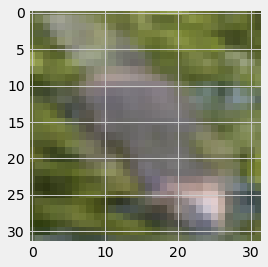

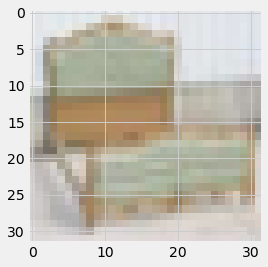

In [81]:
plt.imshow(images_denormalization(cover_list.squeeze()))
plt.show()
plt.imshow(images_denormalization(secret_list.squeeze()))
plt.show()

In [ ]:
writer.close()